In [37]:
import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
import itertools
import csv
import copy
import sklearn.linear_model
import json
import re
from sklearn import preprocessing
%matplotlib inline
%config InlineBackend.figure_format = 'retina'
COLOR_TREAT = "#2ecc71"
COLOR_NO_TREAT = "#e74c3c"
import warnings
warnings.filterwarnings('ignore')

In [38]:
def percent_categorical(item, df=None, grouper='Active Status' , order = None) :
    # plot categorical responses to an item ('column name')
    # by percent by group ('diff column name w categorical data')
    # select a data frame (default is IA)
    # 'Active Status' is default grouper

    # create df of item grouped by status
    grouped = (df.groupby(grouper)[item]
    # convert to percentage by group rather than total count
                .value_counts(normalize=True)
                # rename column 
                .rename('percentage')
                # multiple by 100 for easier interpretation
                .mul(100)
                # change order from value to name
                .reset_index()
                .sort_values(item))

    # create plot
    f, axarr = plt.subplots(1, 2, figsize = (15,8))
    sns.barplot(x=item,
                         y='percentage',
                         hue=grouper,
                         data=grouped,
                         palette='RdBu' , order = order , ax = axarr[0]
                         )
    
    sns.countplot( x = item , data= df , hue = grouper , palette='RdBu' , 
                                order = order , ax = axarr[1])  

# Do the United Nations peace agreements have an impact on conflicts resolution around the world ?

# 1. Introduction

The United Nations often gets criticised for all the wars it could not prevent and its impact in our society has often been questioned. The UN exist since 1945, although until today the amount of conflicts around the world has not significantly diminished, does this mean that the UN is inefficient ? The Israelo-Palestinian conflict is allmost as old as the UN and no Peace Agreements could completely stop it as of today, so does the efforts made through the UN organization are worth the results ? Such a question would request more than a statistical study to be answered. Hence, we will focus on studying the impact of the UN in the domain of conflict resolution. 
 
 Our study aims at giving an objective analysis of the impact of UN peace agreements on the evolution of conflicts around the world. We present the results of our analysis as a data story. Information relative to both conflicts and peace treaties are displayed on a world map in order to get an insight on the impact they have on one another.

notre étude que l'onu a un impact dans la résolution 
pro action reaction

To perform this, we will use the UCDP dataset which provides the information we need about conflicts and peace agreements from 1975 to 2011.

# 2. Facts about conflicts and Peace Agreements

## 2.1 Conflicts

In [39]:
#For nb of deaths
precisedf = pd.read_csv('data/ged171.csv')

#Import the Peace Agreement dataset and the translation table to get the new IDs
pa = pd.read_excel('data/ucdp-peace-agreements.xls')
searchfor = ['UN', 'United Nations' , 'united nations' , 'ONU']
pa_UN = pa[pa['pa_3rd'].astype(str).str.contains('|'.join(searchfor))]
inter = list(set(pa_UN.PAID).intersection(pa.PAID))
pa["UN"] = [1 if ele in inter else 0 for ele in pa.PAID]
pa[pa['UN'] == 1]

reader = csv.reader(open('data/translate_conf.csv', 'r'))

#Create a dictionnary that will have {New ID : Old ID} so we can make the link
d = {}
for row in reader:
    k, v = row
    d[v] = k
    
#pa.CID = pa.CID.astype(dtype=str).replace(to_replace=d )
pa.CID = pa.CID.astype(str)
#print(type(pa.CID))
pa.CID = pa.CID.apply(lambda x: d[x])
pa.CID = pa.CID.astype(dtype = int)

#Import the conflict dataset
df = pd.read_csv('data/ucdp-prio-acd-171.csv')
df.drop(['sidea2nd', 'sideb2nd' , 'terr' , 'year' , 'intensity' , 'startprec' , 'startdate2' , 'epend' , 'ependprec', 'gwnoa', 'gwnoa2nd', 'gwnob', 'gwnob2nd', 'gwnoloc', 'startprec2', 'version', 'sidebid'], axis=1, inplace = True)
clean_df = df.groupby('conflictid').last()
agreements = pa.groupby('CID').last()
UN_agreements = pa[pa['UN']==1].groupby('CID').last()
Other_agreements = pa[pa['UN']==0].groupby('CID').last()
clean_df["agreement"] = [1 if ele in agreements.index else 0 for ele in clean_df.index]
clean_df["UN_agreement"] = [1 if ele in UN_agreements.index else 0 for ele in clean_df.index]
clean_df["Other_agreement"] = [1 if ele in Other_agreements.index else 0 for ele in clean_df.index]
clean_df.rename({'ependdate':'enddate'} , inplace = True, axis = 1)
clean_df['startdate'] = pd.to_datetime(clean_df['startdate'])
clean_df['enddate'] = pd.to_datetime(clean_df['enddate'])
clean_df['duration'] = (clean_df['enddate'] - clean_df['startdate']).dt.days
regiondic = {'1':'Europe' , '2': 'Middle East', '3': 'Asia' , '4': 'Africa' , '5':'Americas' , '1, 3' : 'Asia',
            '1, 2' : 'Middle East' , '1, 4':'Africa' ,'1, 5': 'Americas','1, 2, 3, 5' :'Middle East' , '1, 3, 5' : 'Middle East'}
typedic = {1 : 'Extrasystemic' , 2 : 'Interstate' , 3 : 'Internal' , 4: 'Internationalized'}
incompdic = {1 : 'Territory' , 2: 'Government' , 3: 'Government and Territory'}
cumintdic = {0: 'Less than 1000 deaths' , 1: 'More than 1000 deaths'}
clean_df.region.replace(regiondic , inplace= True)
clean_df.type.replace(typedic , inplace= True)
clean_df.incomp.replace(incompdic , inplace = True)
clean_df.cumint.replace(cumintdic , inplace = True)
ag = clean_df[clean_df['agreement'] == 1]
clean_df[clean_df['agreement'] == 1].head()

,location,sidea,side b,incomp,cumint,type,startdate,enddate,region,agreement,UN_agreement,Other_agreement,duration
conflictid,,,,,,,,,,,,,
209,Philippines,Government of Philippines,CPP,Government,More than 1000 deaths,Internal,1946-07-31,2016-08-20,Asia,1,0,1,25588.0
233,Guatemala,Government of Guatemala,URNG,Government,More than 1000 deaths,Internal,1949-07-18,1995-12-31,Americas,1,1,1,16967.0
234,Israel,Government of Israel,"Hamas, PIJ",Territory,More than 1000 deaths,Internal,1948-05-15,2014-12-24,Middle East,1,0,1,24329.0
269,Nepal,Government of Nepal,CPN-M,Government,More than 1000 deaths,Internal,1960-02-29,2006-09-21,Asia,1,1,1,17006.0
282,Sudan,Government of Sudan,SSLM,Territory,More than 1000 deaths,Internal,1963-12-31,1972-01-31,Africa,1,0,1,2953.0


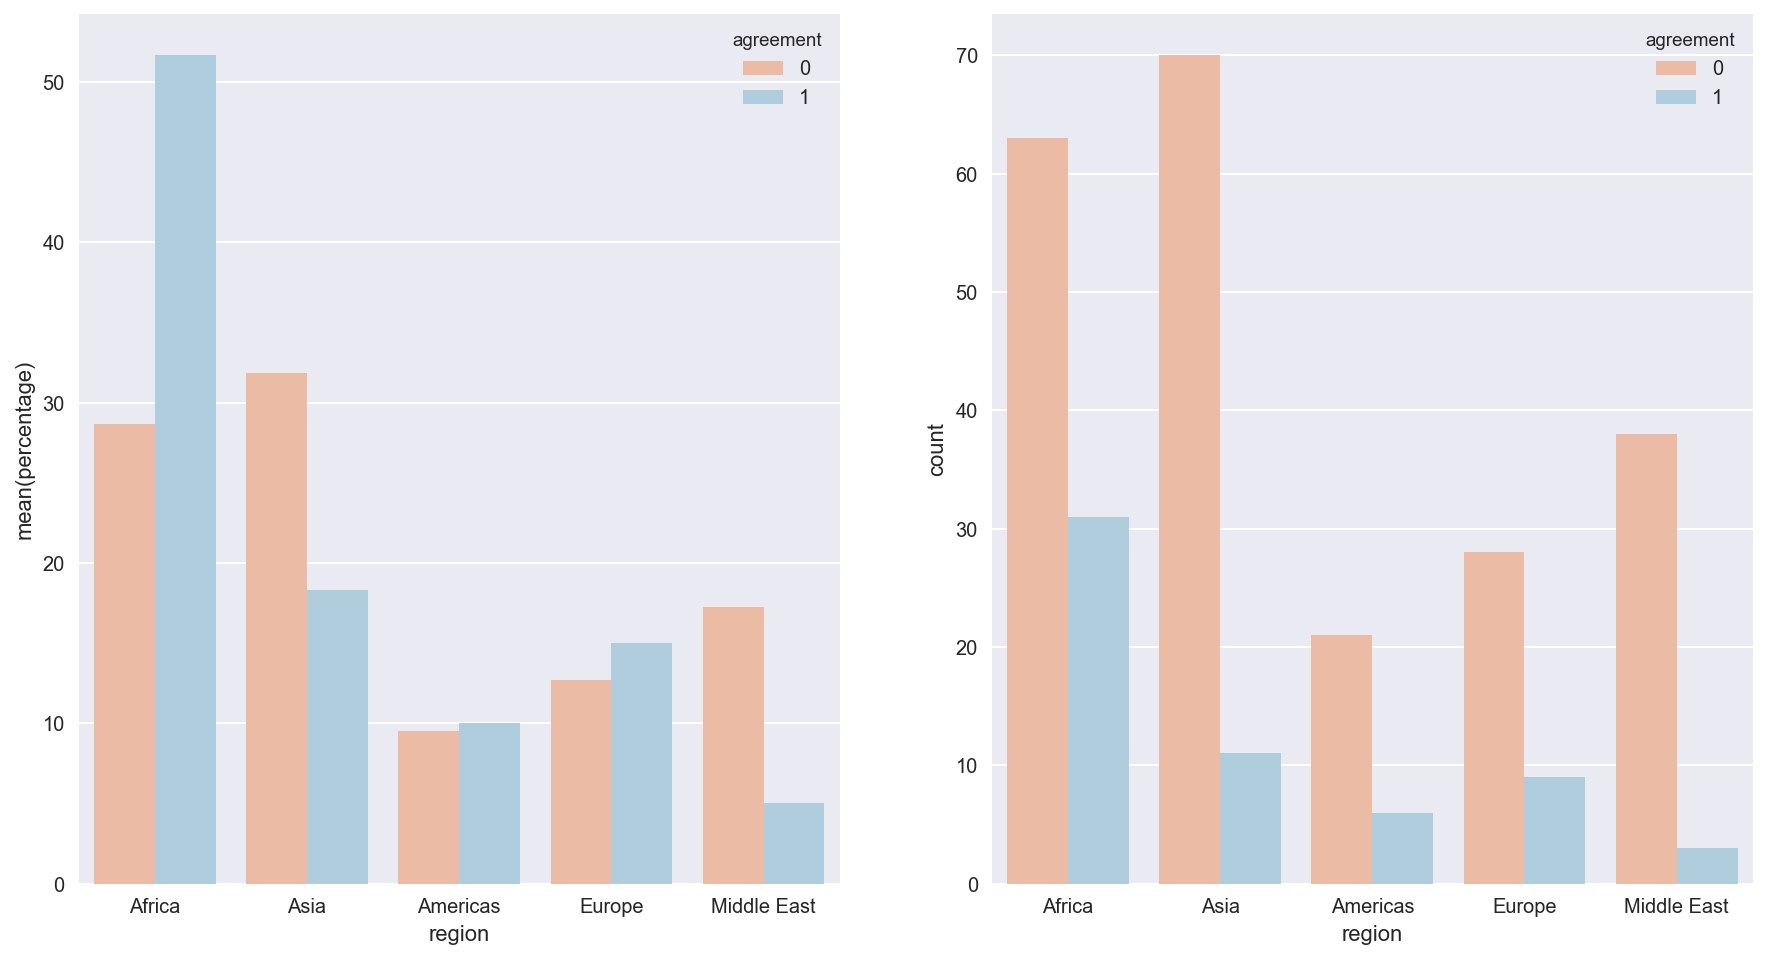

In [40]:
percent_categorical('region' , df= clean_df , grouper = 'agreement' , order = ['Africa' , 'Asia' , 'Americas' , 'Europe' , 'Middle East'])

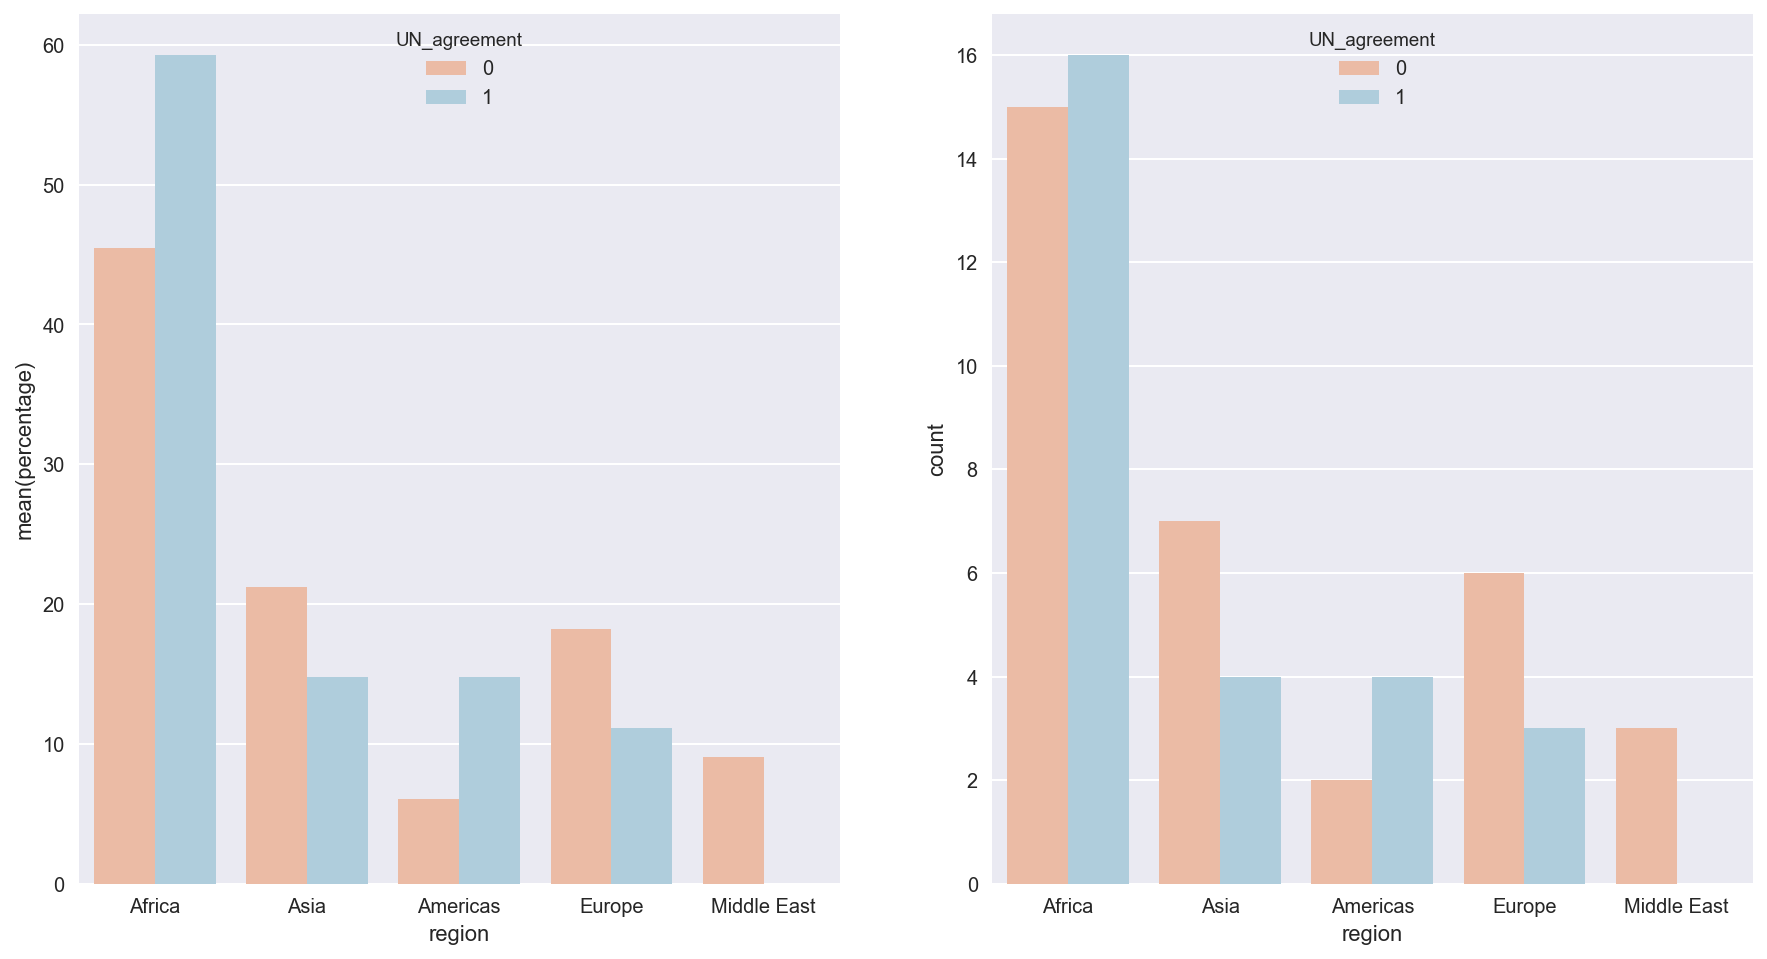

In [41]:
percent_categorical('region' , df= ag , grouper = 'UN_agreement' , order = ['Africa' , 'Asia' , 'Americas' , 'Europe' , 'Middle East']);

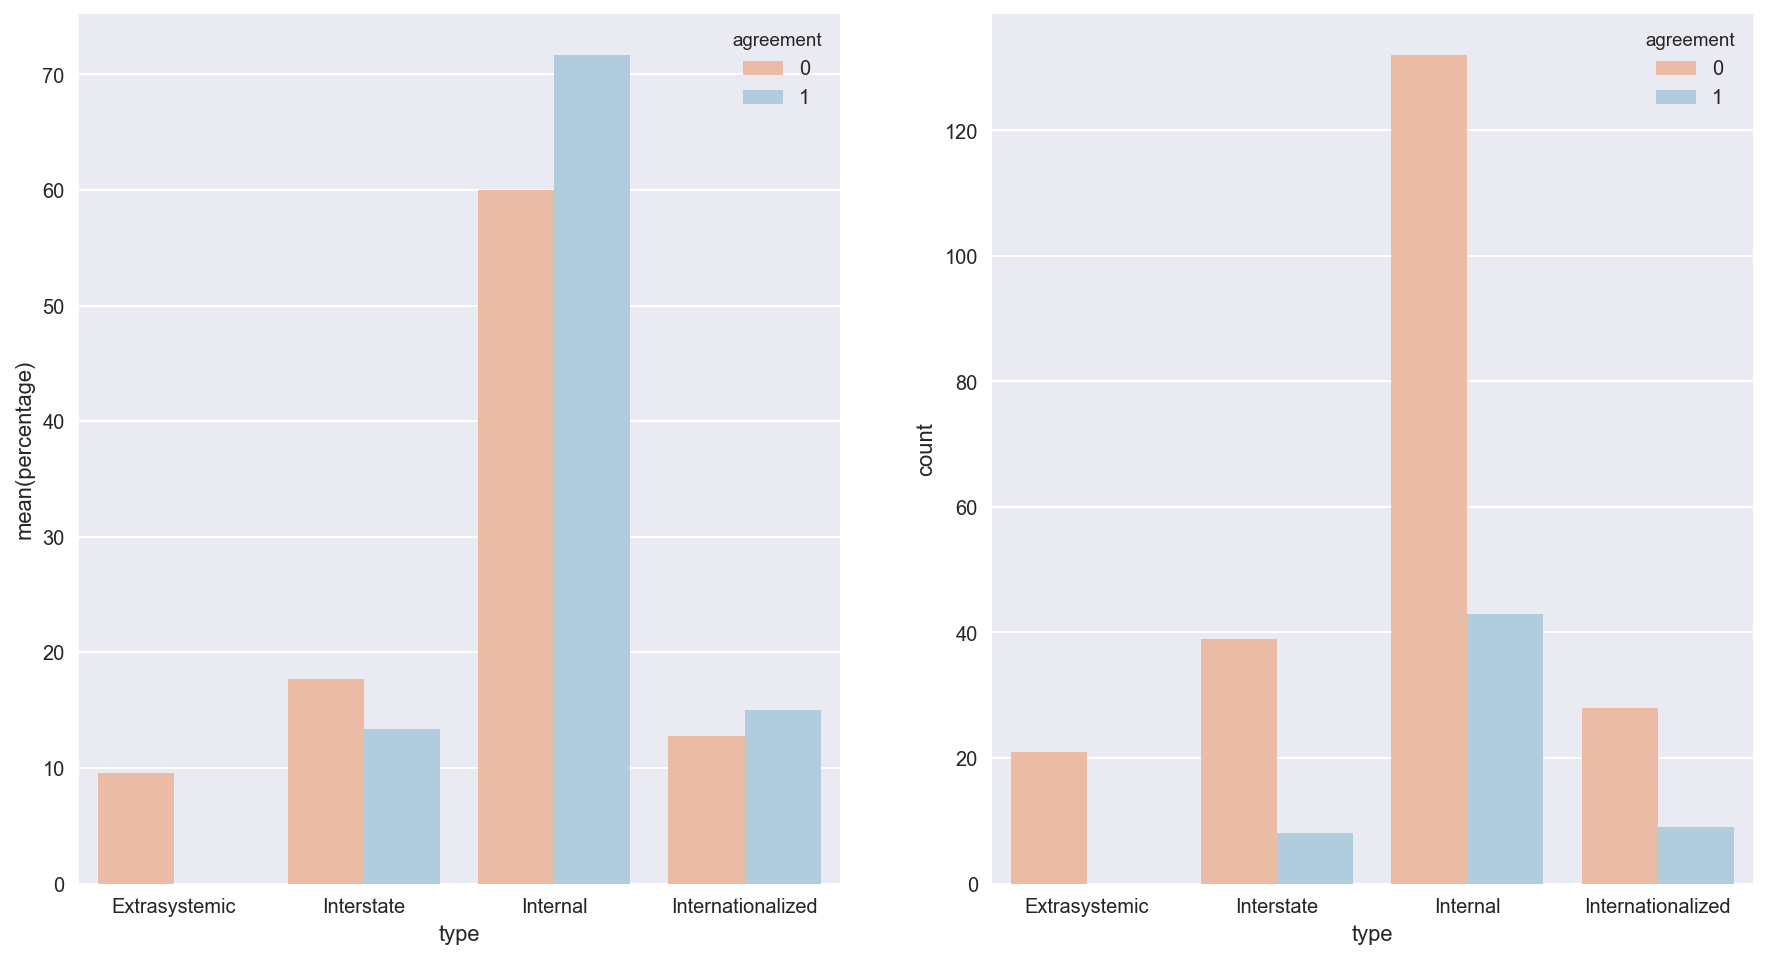

In [42]:
percent_categorical('type' , df= clean_df , grouper = 'agreement' , order = ['Extrasystemic' , 'Interstate' , 'Internal' , 'Internationalized']);

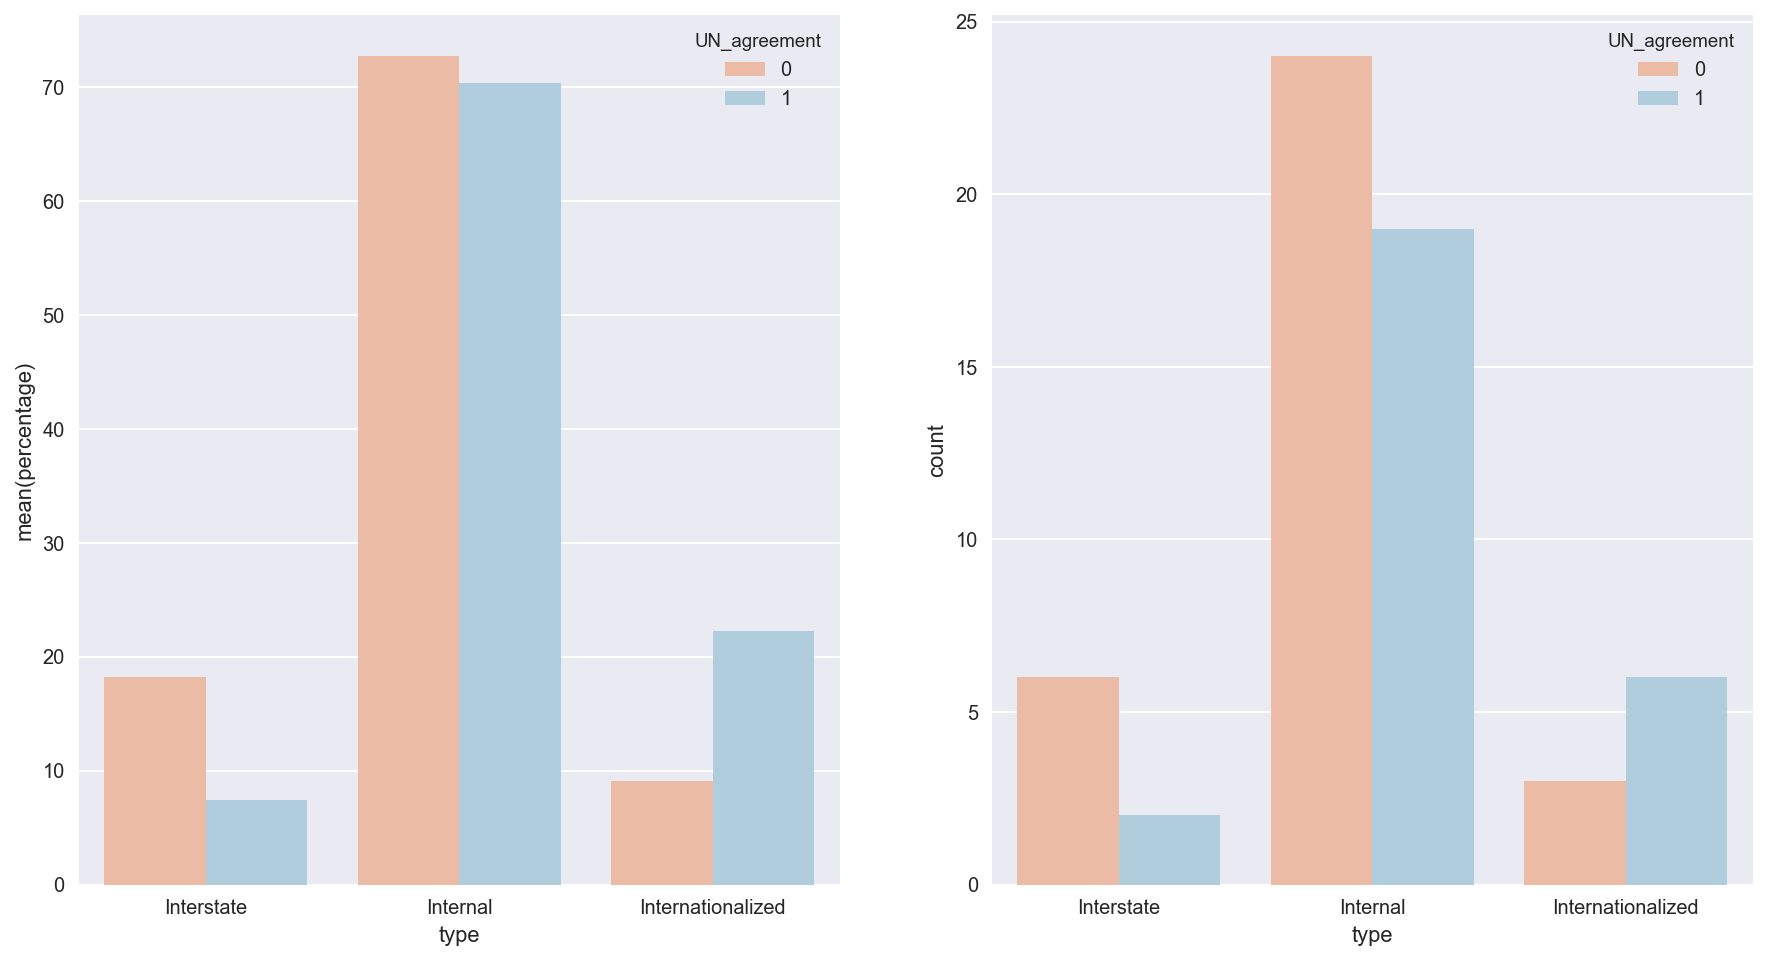

In [43]:
percent_categorical('type' , df= ag , grouper = 'UN_agreement' , order = ['Interstate' , 'Internal' , 'Internationalized']);

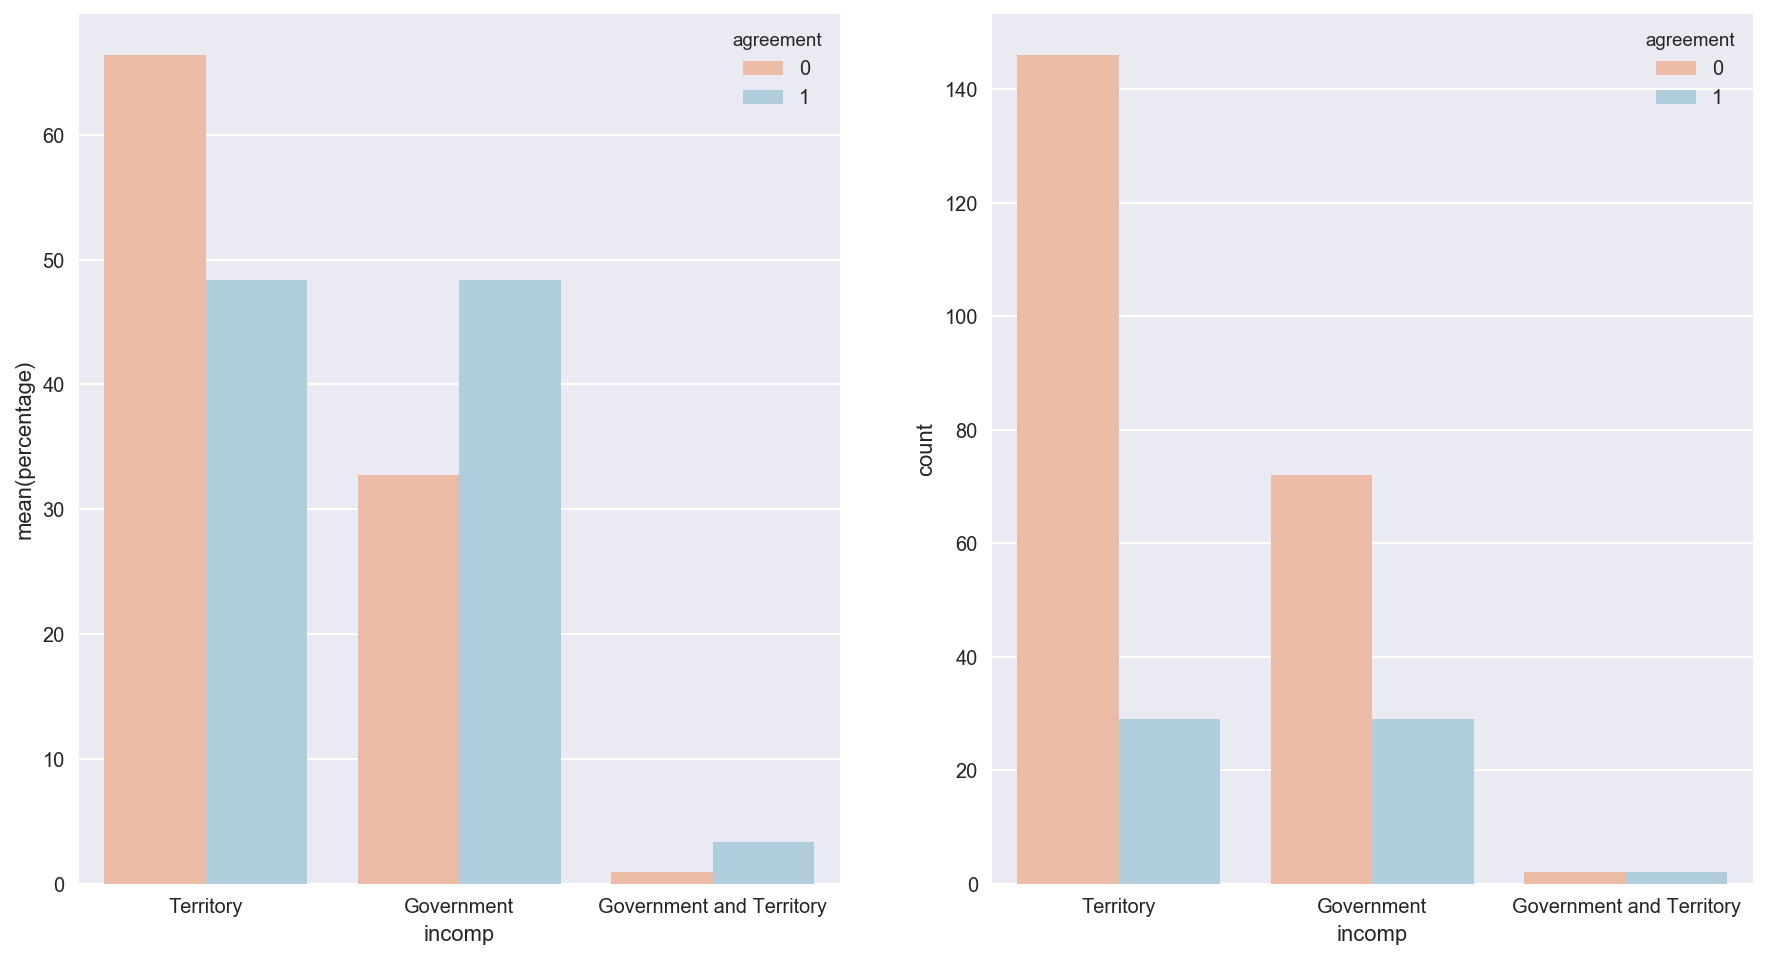

In [44]:
percent_categorical('incomp' , df= clean_df , grouper = 'agreement' , 
                    order = [ 'Territory' , 'Government' , 'Government and Territory'] )

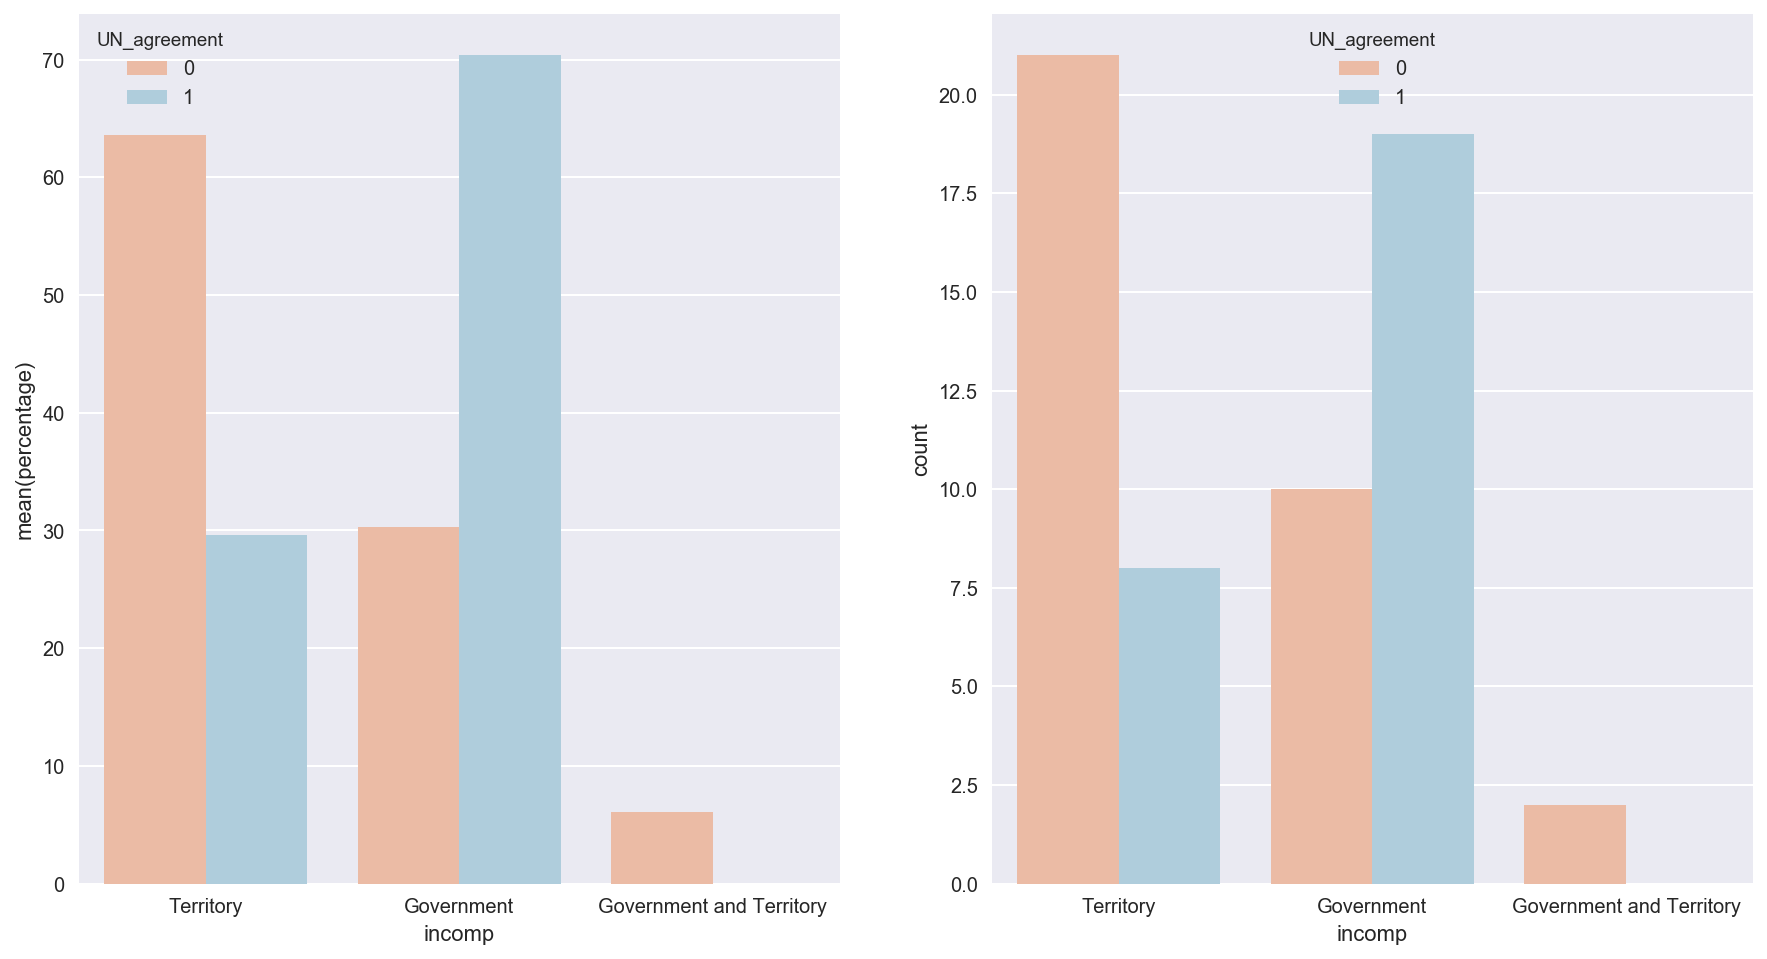

In [45]:
percent_categorical('incomp' , df= ag , grouper = 'UN_agreement' , 
                    order = [ 'Territory' , 'Government' , 'Government and Territory'] )

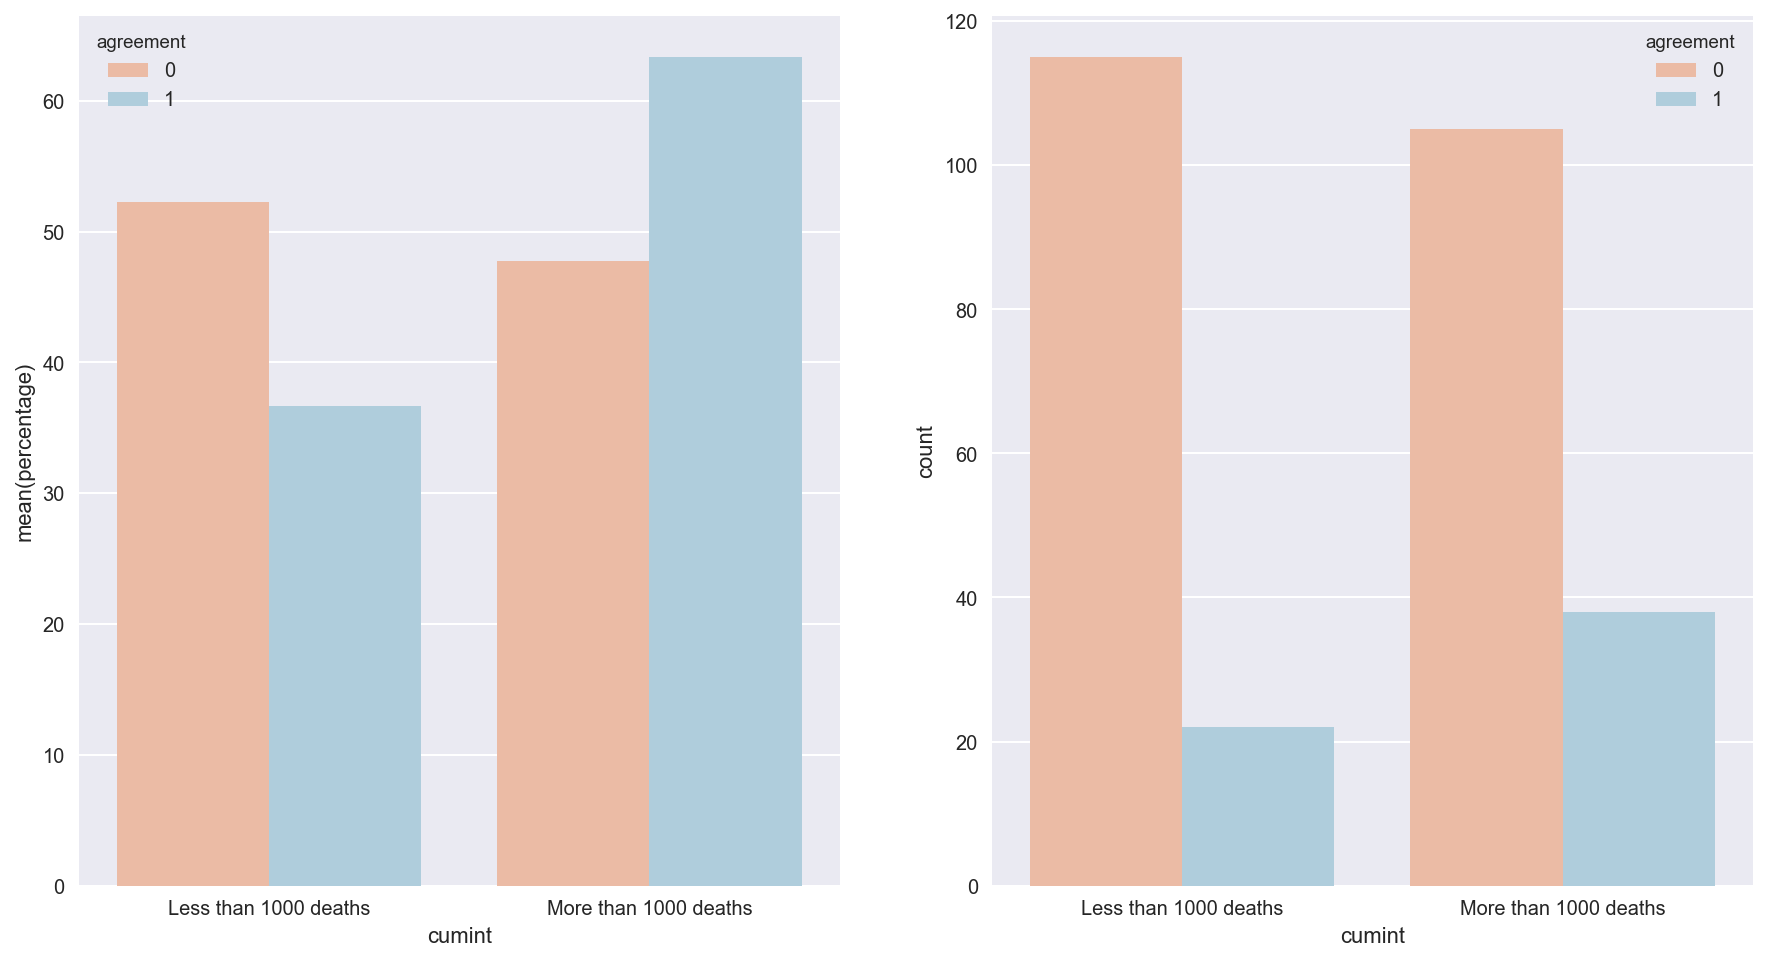

In [46]:
percent_categorical('cumint' , df= clean_df , grouper = 'agreement' , 
                    order = ['Less than 1000 deaths' , 'More than 1000 deaths'] )

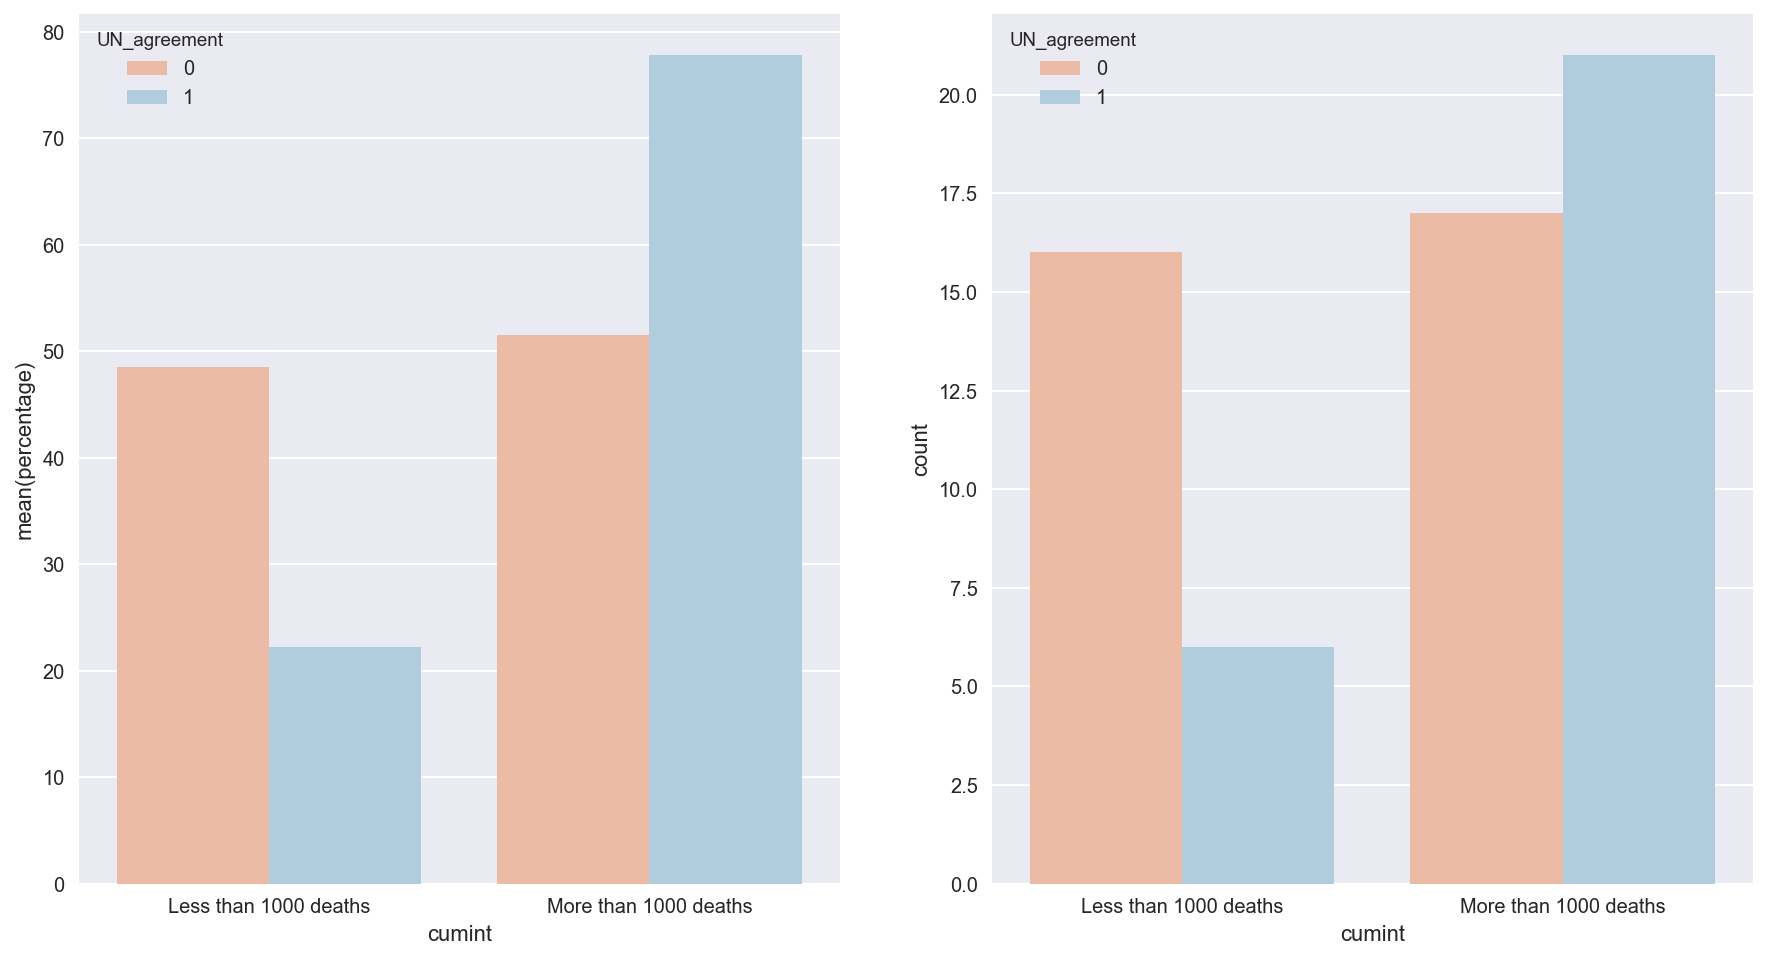

In [47]:
percent_categorical('cumint' , df= ag , grouper = 'UN_agreement' , 
                    order = ['Less than 1000 deaths' , 'More than 1000 deaths'] )

## 2.2 Peace Agreements
The Peace Agreements contain a lot of information about the type of conflict they aim to solve, their own power of violence dissipation and the technicalities that should be set up to bring a more civilized life to the people concerned by the conflict. There are three main types of peace agreements :

-------------- faire un tableau ------------
- Full peace agreement
- Partial peace agreement
- Peace process agreement

--------------faire un tableau---------------

Obviously, this goes from the most executive agreement to the least executive agreement, athough it does not translate the power of a Peace Agreement. Each Peac Agreement is defined by a few charateristics for each type of political provision (a provision is a clause in legal instrument). Below we give a definition for each type of provision.

-------------- faire un tableau ------------
- Behavioral conduct of the warring parties
- Regulation of governmental incompatibility
- Regulation of territorial incompatibility
- Justice issues

-------------- faire un tableau ------------

8 peace agreements with UN. out of the 8 PAs only 1 is still valid as of today
PA with UN represents X% of the PA's. Hence a matching analysis must be made to 

In [48]:
pa = pd.read_excel('data/ucdp-peace-agreements.xls')
cols = ['bwdID', 'pa_comment', 'c_sign', 'c_3rd', 'c_duration', 'Reaffirm ID', 'Comment', 'txt', 
        'Link to fulltext agreement', 'ProcID', 'Frame', 'All', 'Counter' , 'Duration']
pa.drop(columns=cols, inplace=True)
regiondic = {
    1:'Europe',
    2:'Middle East',
    3:'Asia',
    4:'Africa',
    5:'Americas'
}
paType = {
    1:'Full',
    2:'Partial',
    3:'Peace Process'
}
pa['pa_type'].replace(paType, inplace=True)
pa['Region'].replace(regiondic, inplace=True)

searchfor = ['UN', 'United Nations' , 'united nations' , 'ONU']
pa_UN = pa[pa['pa_3rd'].astype(str).str.contains('|'.join(searchfor))]
inter = list(set(pa_UN.PAID).intersection(pa.PAID))
pa["UN"] = [1 if ele in inter else 0 for ele in pa.PAID]

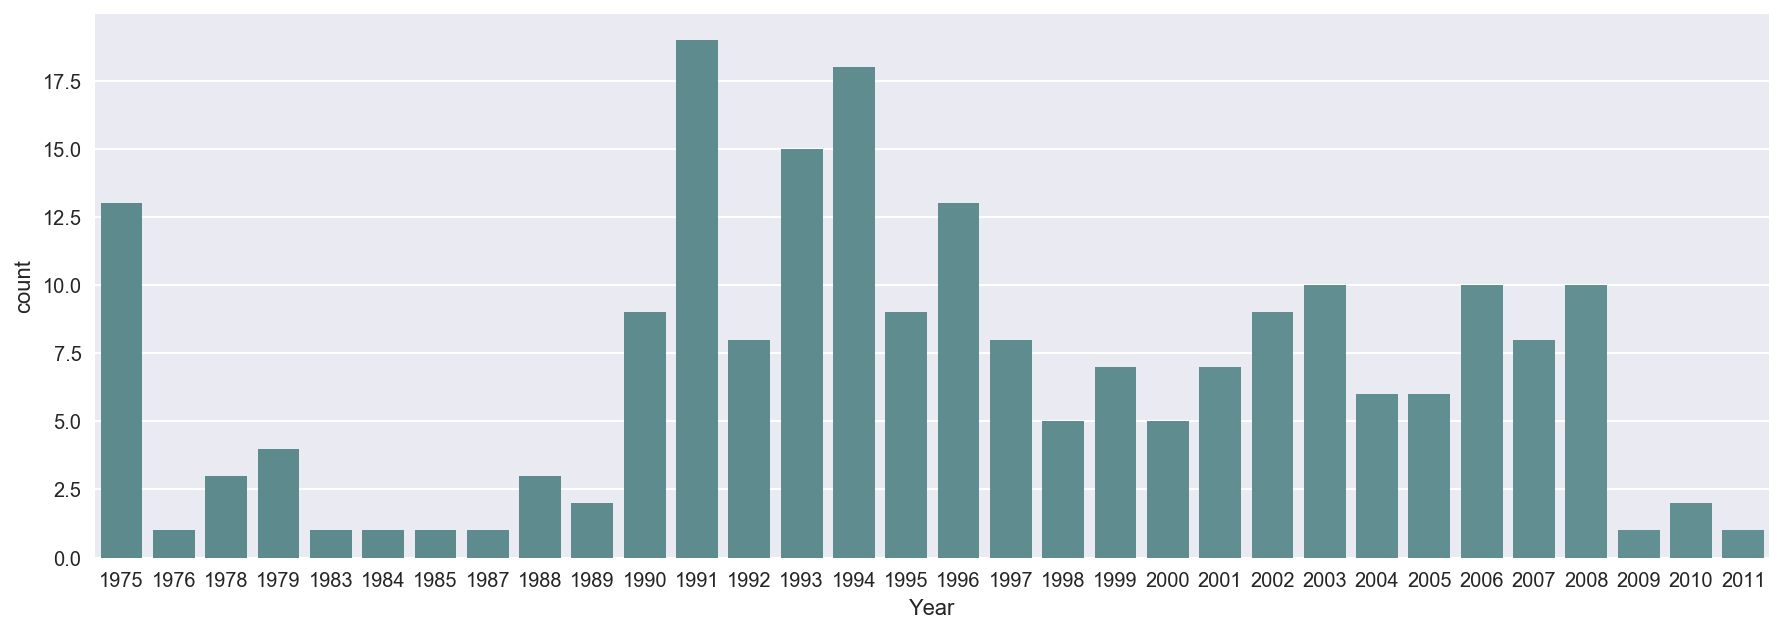

In [49]:
plt.figure(figsize=(15,5))
sns.countplot(x='Year', data=pa, palette=sns.cubehelix_palette(800, start=2, rot=0.3, dark=0.5, light=.95, reverse=True))

### Year distibution of Peace agreements
1991 is the year where most peace agreements were signed. There has been two periods with a low amount of peace agreement, from 1983 to 1987 and from 2009 to 2011.

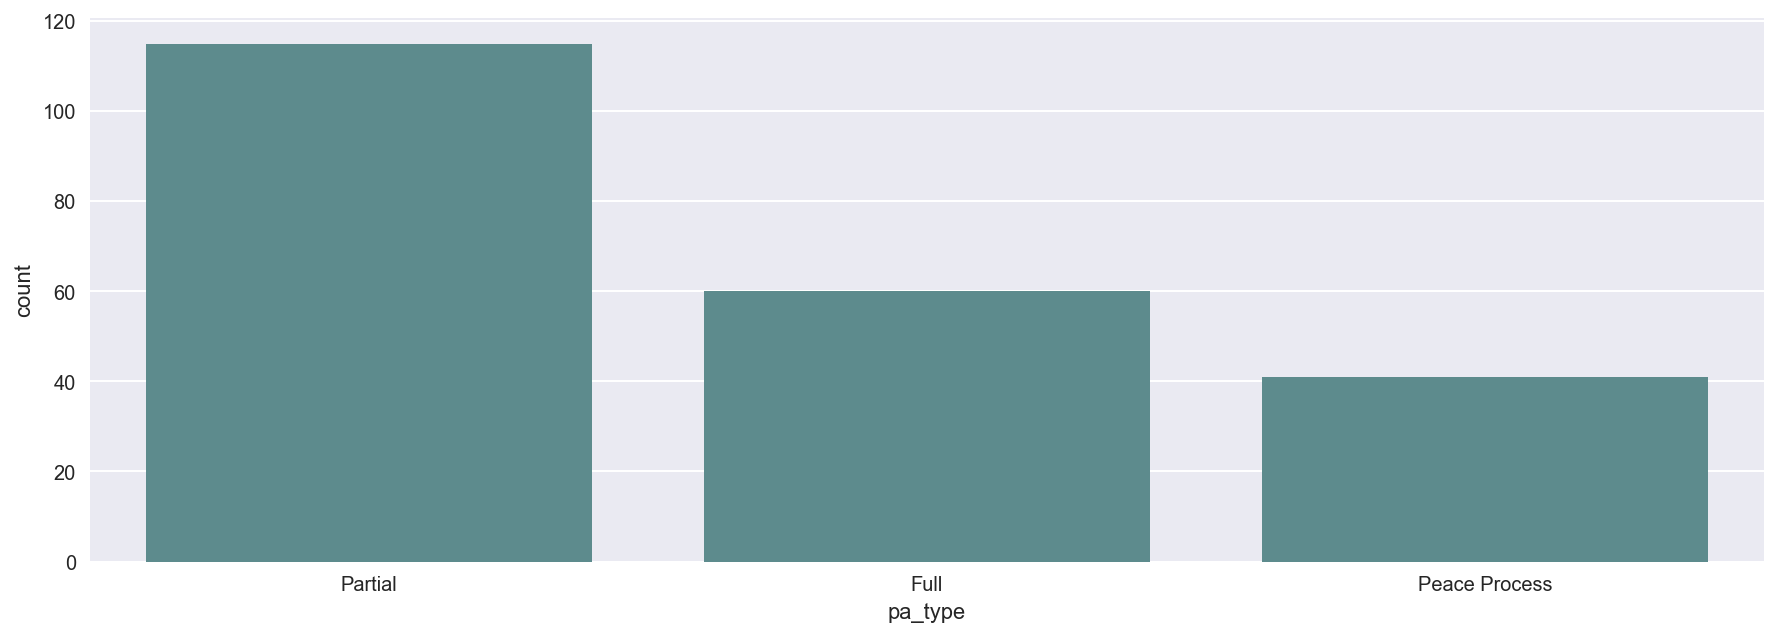

In [51]:
plt.figure(figsize=(15,5));
sns.countplot(x='pa_type', data=pa, palette=sns.cubehelix_palette(800, start=2, rot=0.3, dark=0.5, light=.95, reverse=True),
             order= pa.pa_type.value_counts().index)#col='UN', kind='count', size=6);

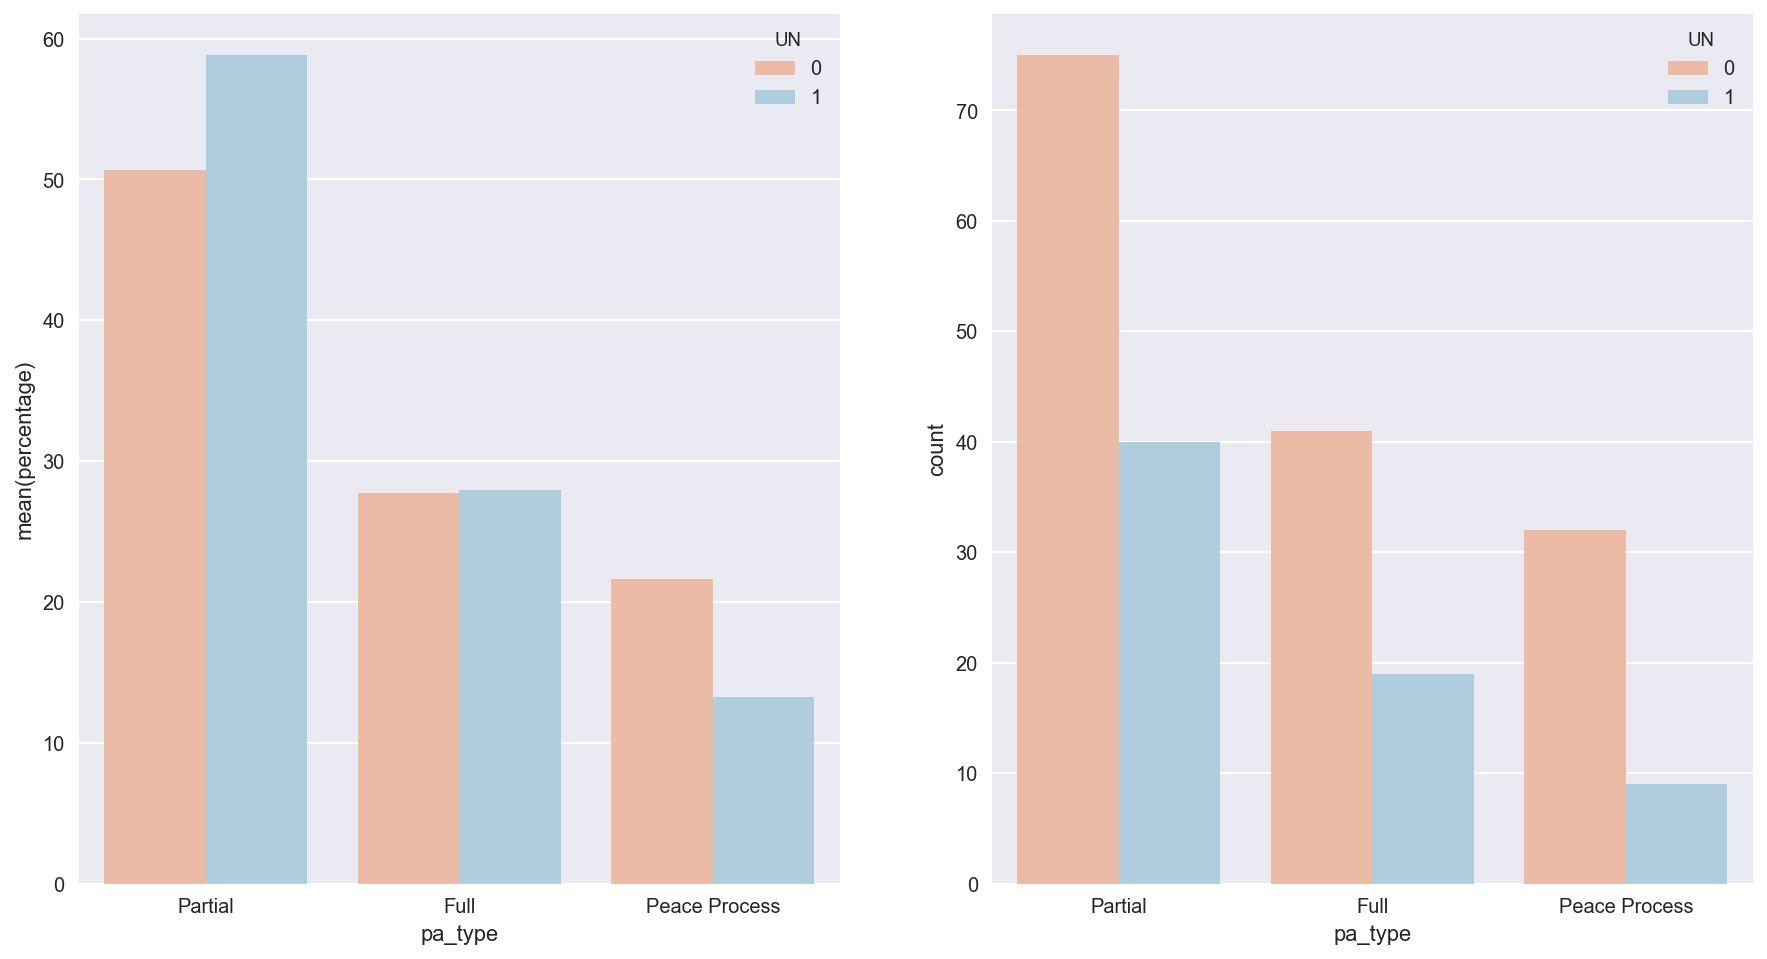

In [52]:
percent_categorical('pa_type' , df=pa , grouper = 'UN' , order = pa.pa_type.value_counts().index);

### Executive strength of peace agreements
Most peace agreements are partial peace agreements. Peace Process agreements are generally agreements that are signed at the begginning of a conflict and call for future peace agreements. This figure that UN involvment in the peace agreements does not change much the distribution of the the PAs types. 

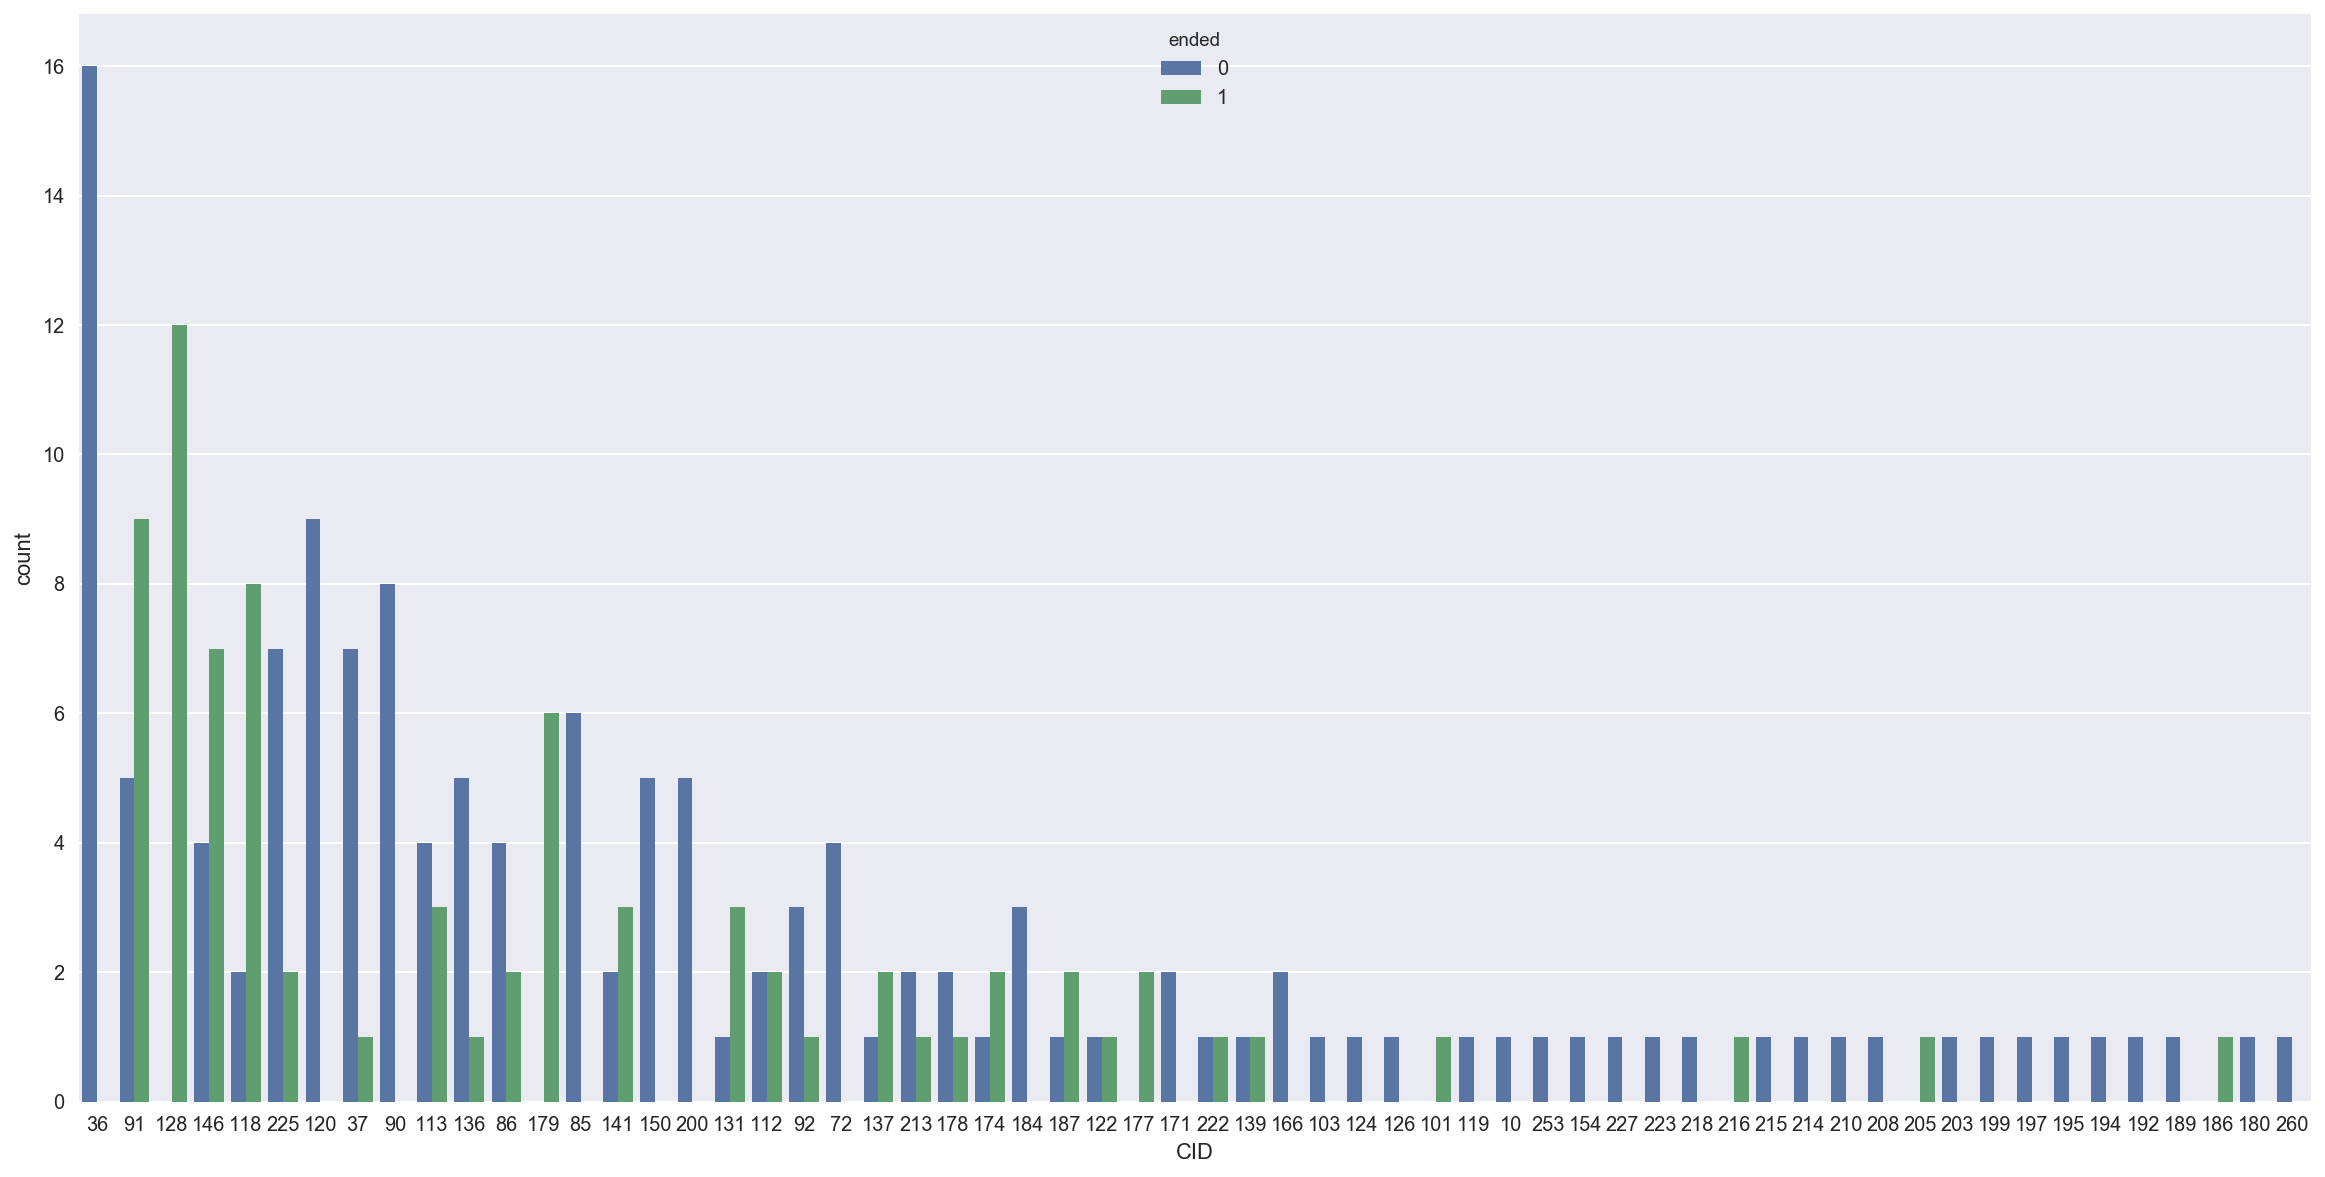

In [53]:
plt.figure(figsize=(20,10))
sns.countplot(x='CID', data= pa, hue='ended', order=pa.CID.value_counts().index)

This figure shows that some conflicts used more than one Peace Agreement. 

Conflict 36 is an example of a conflict where multiple agreements were needed to achieve peace. This conflict concerns the Government of Guatemala and the Guatemalan National Revolutionary Unity. 16 peace agreements were signed in six years and all of them are still valid as of today. 

On the other hand, conflict 128 is an example of a conflict where all of its agreements ended. This conflict was between Iran and Iraq. Each of the 12 agreements were signed in 1975. Despite the first agreements, that was signed by The Shah of Iran and Saddam Hussein, all of them were signed by the same two representatives of Iran and Iraq, respectively by ABBAS-ALI KHALATBARY, Minister for Foreign Affairs of Iran and SAADOUN HAMADI, Minister for Foreign Affairs of Iraq. These agreements that were active in 1975, were than terminated between 1975 and 1980 until they were reactivated. Although the agreements were reactivated in 1980. Conflicts between Iran and Iraq did not stop in 1980, hence we can consider those agreements as failures.

**Conflict 179 :**

This conflict concerned the Government of the Republic of Rwanda and the Rwandese Patriotic Front. The six agreements were signed between 1992 and 1993. The incompatibility is governmental.
The five first agreements were signed to provide partial peace and the last one in august 1993 was supposed to prvide full peace to the region. None of the agreements provided for the holding of national talks to solve incompatibility and for the integration of rebels into civil service.
In April 1994, a genocide broke out and the peace agreements were never fully implemented.

**Conflict 101 : **

This conflict originated from a governmental incompatibility between South Africa and Namibia. The agreement was signed in 1978 and lasted two months. The agreement contained provisions for political incompatibilities leading to independence for Namibia, justice provisions with the return of refugees and release of political prisoners and behavior regulations such as (ceasefire, withdrawal of foreign forces and demobilisation of local armies).
 
**Conflict 216 : **

Government of Guinea Bissau - Military Junta for the Consolidation of Democracy, Peace and Justice. Incompatibility 2, The peace agreement lasted for 6 months.

** Conflict 205 : **

The agreement covered indigenous rights and culture and strengthened the position of the indigenous people in Mexico. incompatibility 2. The accord was never implemented and thus further peace talks that were planned in September the same year were suspended by EZLN. No exact date for the ending of the peace accord has been found.

All of the conflicts that were treated by only one agreement and had terminated originated from governmental imcompabilities. 

### Regulation of warring parties behavior
Most Peace Agreements that contain behavioral clauses provide for a ceasefire and the disarmement of foreign forces. s were never terminated. The ones which provided for the creation of a new national army or the integration of rebels into the army and the withdrawal of foreign forces.

### Regulation of governmental incompatibilities
X% of the Peace agreements concern governmental incompabiliities.
Peace agreements that provide governmental provisions mostly provide for elections and electoral reforms for rebel integration into the interim government. The main difference that can be observed between UN agreements and non UN agreements is that the UN agreements usually provide provisions for an interim government and elections while non UN agreements msotly only provide provisions for an election.

### Regulation of territorial incompatibilities
Territorial conflicts are mostly treated by Peace Agreements with clauses about the demarcation of a border or the government granting the disputed region to the other warring party.

### Regulation of justice issues
The most recurring clause in peace agreements justice issue is the release of prisoners. 

# 3. Impact of the UN
The UN is present in 31% of the agreements but took part to at least on PA for allmost all conflicts. Hence we will set up our treat and control group on conflicts where the UN 

# 4. Map

# 5. Conclusions
Il faut bien comprendre que c'est pas le seul rôle de l'onu dont le rôle principal est d'être un lieu de rencontre. Th UN main job stands more in the proaction than in the reaction of conflicts. For further research, An analysis of the the interactions between chef d'états en tension level between contries 